In [2]:
import torch as T
import torchvision
import numpy as np
from matplotlib import pyplot as pt

device = T.device('cuda:0')

In [4]:
bs = 256

mnist_train = torchvision.datasets.MNIST(train=True, download=True, transform=torchvision.transforms.ToTensor())
loader_train = T.utils.data.DataLoader(mnist_train, bs, shuffle=False)

In [29]:
class CNN(T.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = T.nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = T.nn.Conv2d(32, 32, 3, 2, 1)
        self.conv3 = T.nn.Conv2d(32, 32, 3, 2, 1)
        self.conv4 = T.nn.Conv2d(32, 32, 3, 2, 1)
        self.fc = T.nn.Linear(32*4*4, 10)
    def forward(self, x):
        x = self.conv1(x).relu()
        x = self.conv2(x).relu()
        x = self.conv3(x).relu()
        x = self.conv4(x).relu().view(-1,32*4*4)
        x = self.fc(x)
        return x

model = CNN().to(device)
print(sum(a.numel() for a in model.parameters()))

opt = T.optim.Adam(model.parameters(), 0.001)

33194


In [30]:
udiag = (T.triu(T.ones(10,10)) + 1e-10).log().to(device)

def rq_ranking_loss(preds, labels):
    # label pairs define the prior (bs/2, 10, 10)
    logprior = T.zeros((labels.shape[0]//2, 10, 10), device=device)
    logprior[labels[::2] >= labels[1::2]] = udiag
    logprior[labels[::2] < labels[1::2]] = udiag.T
    
    logq = preds.log_softmax(1) # (bs, 10) normalized over q
    logz = logq.log_softmax(0) # (bs, 10) normalized over batch
    logz_pairs = logz[::2].unsqueeze(1) + logz[1::2].unsqueeze(2) # (bs/2, 10, 10)
    
    logr = (logz_pairs + logprior).view(-1, 10*10).log_softmax(1).view(-1,10,10) # (bs/2, 10, 10)
    logr_marginal1 = logr.logsumexp(1)
    logr_marginal2 = logr.logsumexp(2)
    logtarget = T.stack([logr_marginal1,logr_marginal2],1).view(-1,10) # (bs, 10)
    
    cross_entropy = -( logq * logtarget.exp()).sum(1).mean()
    target_entropy = -(logtarget * logtarget.exp()).sum(1).mean()
    return cross_entropy, target_entropy

nll_loss = T.nn.NLLLoss()

conf = np.zeros((10,10))
conf_log = []

for epoch in range(10):
    loss_log = []
    acc_log = []
    nll_log = []
    
    for it,batch in enumerate(loader_train):
        x = model(batch[0].to(device))
        y = batch[1].to(device)
        
        opt.zero_grad()
        
        cross_entropy, target_entropy = rq_ranking_loss(x, y)
        nll = nll_loss(x.log_softmax(1),y) # for logging only    
        loss = cross_entropy - target_entropy # KL(r||q)       
        loss.backward()

        opt.step()
        
        loss_log.append(loss.item())
        nll_log.append(nll.item())
        acc_log.append((x.argmax(1)==y).float().mean().item())
        
        for a,b in zip(x.argmax(1).cpu().numpy(), y.cpu().numpy()):
            conf[b,a]+=1

        if it%10==0:
            conf_log.append(conf.copy())
            conf *= 0
             
    print(f'Epoch {epoch}: ', end=' ')
    print(f'RQ loss {sum(loss_log)/len(loss_log)}', end=' ')
    print(f'NLL {sum(nll_log)/len(nll_log)}', end=' ')
    print(f'Accuracy {sum(acc_log)/len(acc_log)}', end=' ')
    print()
       

Epoch 0:  RQ loss 0.09345662593841553 NLL 1.746980909083752 Accuracy 0.3404255319148936 
Epoch 1:  RQ loss 0.05467299654128704 NLL 1.0099436194338698 Accuracy 0.6313386526513607 
Epoch 2:  RQ loss 0.03720697896911743 NLL 0.33254010295297237 Accuracy 0.9112256207364671 
Epoch 3:  RQ loss 0.024569295568669096 NLL 0.16597839222943528 Accuracy 0.95346852845334 
Epoch 4:  RQ loss 0.01662719966249263 NLL 0.138970495292798 Accuracy 0.9614971188788718 
Epoch 5:  RQ loss 0.012257143117963 NLL 0.1403332485520142 Accuracy 0.9638741135597229 
Epoch 6:  RQ loss 0.00980620322392342 NLL 0.1429668214766586 Accuracy 0.9650820037151905 
Epoch 7:  RQ loss 0.009153535748098759 NLL 0.1447638308074563 Accuracy 0.967032358240574 
Epoch 8:  RQ loss 0.008206992529015592 NLL 0.1449765764642507 Accuracy 0.9671431739279565 
Epoch 9:  RQ loss 0.006345011813050889 NLL 0.1507218978962207 Accuracy 0.9693816489361702 


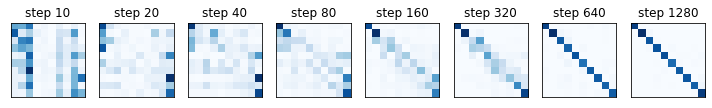

In [31]:
pt.figure(figsize=(10,10))
for i in range(1,9):
    pt.subplot(1,8,i)
    pt.xticks([]);pt.yticks([])
    pt.title(f'step {10*2**(i-1)}')
    pt.imshow(conf_log[2**(i-1)],cmap='Blues',vmin=0)
pt.tight_layout()
pt.show()